# attempt at using seasonality to identify anomalies that might be attributed to window opening and closing 
* Jan 18, 2023

In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import math
import sys
import os
from collections import OrderedDict
from statsmodels.tsa.seasonal import STL

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import seaborn.objects as so
# Apply the default theme
sns.set_theme()
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../scripts")
from helpers import *

In [20]:
from statsmodels.tsa.seasonal import MSTL

ImportError: cannot import name 'MSTL' from 'statsmodels.tsa.seasonal' (/Users/julietnwagwuume-ezeoke/_UILCode/windows/localwindowsenv/lib/python3.10/site-packages/statsmodels/tsa/seasonal.py)

In [2]:
df = pd.read_csv("../constants/td_ambient_102022.csv" )
df["DateTime"] = pd.to_datetime(df["DateTime"])
df

,DateTime,Temp C,RH %,Room,Ambient Temp,Ambient RH,Window Open
0,2022-07-20 07:20:00,23.189,51.268,0,14.333333,30.555556,1
1,2022-07-20 07:20:30,23.189,51.362,0,14.333333,30.555556,1
2,2022-07-20 07:21:00,23.189,51.488,0,14.333333,30.555556,1
3,2022-07-20 07:21:30,23.189,51.457,0,14.333333,30.555556,1
4,2022-07-20 07:22:00,23.165,51.517,0,14.333333,30.555556,1
...,...,...,...,...,...,...,...
123601,2022-09-11 07:58:00,29.196,50.861,1,19.611111,30.000000,0
123602,2022-09-11 07:58:30,29.196,50.861,1,19.611111,30.000000,0
123603,2022-09-11 07:59:00,29.196,50.796,1,19.611111,30.000000,0
123604,2022-09-11 07:59:30,29.196,50.796,1,19.611111,30.000000,0


In [3]:
# split data by room and by experiment 
with open('../constants/window_treatment.json') as f:    
    window_treatment = json.load(f)

exp_a_end = str2dt(window_treatment["072522"]["cutoff_times"]["end"])
exp_b_end = str2dt(window_treatment["081622"]["cutoff_times"]["end"])

# only consider experiment a 
df_a = df.loc[df["DateTime"] < exp_a_end]
df_a.head()

# split into room 0 and room 1 
df1, df0 = [x.reset_index(drop=True) for _, x in df_a.groupby(df_a['Room'] < 1)]

# season ~ 1 day 

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df0["DateTime"],
    y=df0["Temp C"], 
    mode='lines'
))

fig.update_layout(title='Room 0 Data',
                   xaxis_title='Dates',
                   yaxis_title='Temperature (ºC)')

In [5]:
# make the datetime the index of the dataframe 
df01 = df0.set_index(["DateTime"])
df01

,Temp C,RH %,Room,Ambient Temp,Ambient RH,Window Open
DateTime,,,,,,
2022-07-20 07:20:00,23.189,51.268,0,14.333333,30.555556,1
2022-07-20 07:20:30,23.189,51.362,0,14.333333,30.555556,1
2022-07-20 07:21:00,23.189,51.488,0,14.333333,30.555556,1
2022-07-20 07:21:30,23.189,51.457,0,14.333333,30.555556,1
2022-07-20 07:22:00,23.165,51.517,0,14.333333,30.555556,1
...,...,...,...,...,...,...
2022-07-24 07:17:30,23.309,52.009,0,14.722222,30.555556,1
2022-07-24 07:18:00,23.285,52.069,0,14.722222,30.555556,1
2022-07-24 07:18:30,23.285,52.100,0,14.722222,30.555556,1


In [6]:
df01["Temp C"]

DateTime
2022-07-20 07:20:00    23.189
2022-07-20 07:20:30    23.189
2022-07-20 07:21:00    23.189
2022-07-20 07:21:30    23.189
2022-07-20 07:22:00    23.165
                        ...  
2022-07-24 07:17:30    23.309
2022-07-24 07:18:00    23.285
2022-07-24 07:18:30    23.285
2022-07-24 07:19:00    23.309
2022-07-24 07:19:30    23.309
Name: Temp C, Length: 11520, dtype: float64

In [7]:
df02 = df01.asfreq(pd.infer_freq(df01.index))

In [14]:
df02

,Temp C,RH %,Room,Ambient Temp,Ambient RH,Window Open
DateTime,,,,,,
2022-07-20 07:20:00,23.189,51.268,0,14.333333,30.555556,1
2022-07-20 07:20:30,23.189,51.362,0,14.333333,30.555556,1
2022-07-20 07:21:00,23.189,51.488,0,14.333333,30.555556,1
2022-07-20 07:21:30,23.189,51.457,0,14.333333,30.555556,1
2022-07-20 07:22:00,23.165,51.517,0,14.333333,30.555556,1
...,...,...,...,...,...,...
2022-07-24 07:17:30,23.309,52.009,0,14.722222,30.555556,1
2022-07-24 07:18:00,23.285,52.069,0,14.722222,30.555556,1
2022-07-24 07:18:30,23.285,52.100,0,14.722222,30.555556,1


In [ ]:
# need to figure out what period is... => 12 is for months... 12/3, think its related to year.. so how many 30s intervals in a year...
# not going to work, sea

In [38]:
# stl decomposition 
period1 = 24/(24*4) # period must be a positive integer >= 2
period2 = 24*4
period3 = 60*24*2 # 30s period 
period4 = 60*24*2*2 
period = (60*24)/2


In [40]:
stl = STL(df02["Temp C"], period=period3) 
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

ValueError: period must be a positive integer >= 2

In [32]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=("Room 0 Original Data", "Seasonal", "Trend", "Residual"))
fig.add_trace(go.Scatter(
x=df02.index,
y=df02["Temp C"],
), row=1, col=1)

fig.add_trace(go.Scatter(
x=df02.index,
y=seasonal,
), row=2, col=1)

fig.add_trace(go.Scatter(
x=df02.index,
y=trend,
), row=3, col=1)

fig.add_trace(go.Scatter(
x=df02.index,
y=resid,
), row=4, col=1)

In [25]:
resid

DateTime
2022-07-20 07:20:00   -0.118783
2022-07-20 07:20:30   -0.115730
2022-07-20 07:21:00   -0.115741
2022-07-20 07:21:30   -0.114878
2022-07-20 07:22:00   -0.120142
                         ...   
2022-07-24 07:17:30    0.197990
2022-07-24 07:18:00    0.192725
2022-07-24 07:18:30    0.201031
2022-07-24 07:19:00    0.198830
2022-07-24 07:19:30    0.198819
Name: resid, Length: 11520, dtype: float64

<AxesSubplot:>

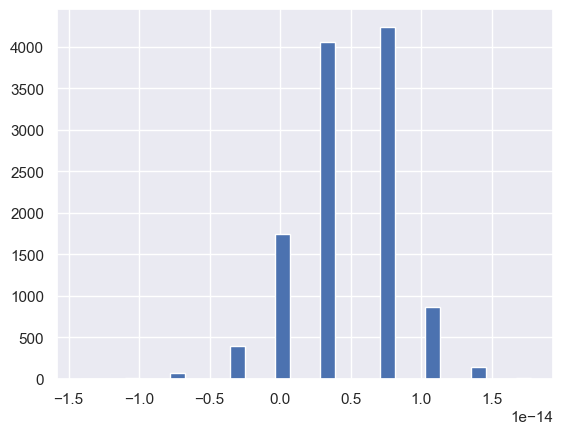

In [33]:
resid.hist(bins=30)